<a href="https://colab.research.google.com/github/prog815/progOrder/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D1%8F_%D0%B6%D0%B8%D0%B7%D0%BD%D0%B8_%D0%BE%D1%80%D0%B4%D0%B5%D1%80%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Эксперимент: "Время жизни ордера"

Проект: "Оптимизация инвестиционных портфелей методами машинного обучения"

https://github.com/prog815/portfOptim

Енин А.В.

Оренбург

15.01.2021

[VK](https://vk.com/alekseyenin)
[OK](http://ok.ru/profile/404477133)
[Twitter](https://twitter.com/EninAleksey)
[FB](https://www.facebook.com/alex.prog.1)
[Telegramm](https://t.me/AleseyEnin)
[Habr](https://habr.com/ru/users/eavprog/posts/)
[VC](https://vc.ru/u/262921-aleksey-enin)
[GitHub](https://github.com/prog815)

# Загрузка библиотек

In [ ]:
! pip install finam-export
! pip install git+https://github.com/prog815/progGA
! pip install git+https://github.com/prog815/progOrder

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-yojdupq2
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-yojdupq2
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3732 sha256=caa89223475c84858b340808a499d8825ec3728e97e89c0f4bbe70a944aa528d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nqt7v_1p/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-q5rqwb_3
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-q5rqwb_3
  Created wheel for progOrder: filename=progOrder-0.0.5-cp36-none-any.whl size=2485 sha256=0e66efb2f3d5a4b8dd383e1d25e9f11c0d053450d85ef3a8fa20b65cc1ca1a10
  Stored in directory: /tmp/pip-ephem-wheel-cache-hct82y39/wheels/55/73/64/80cff258e67e5c7a4b92084f656d1e4f2f48a7543da44468f2
Successfully built progOrder


In [ ]:
from finam import Exporter, Market
import datetime
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
from progGA import ListGenetic
from progOrder import getBuySellForData, kach, bs2y, y2bs
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix,f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Загрузка данных

In [ ]:
exporter = Exporter()
sber = exporter.lookup(code='SBER', market=Market.SHARES)
data = exporter.download(sber.index[0],market=Market.SHARES,start_date=datetime.date(2003, 1, 1))
data.drop('<TIME>',axis=1,inplace=True)
data.set_index('<DATE>',inplace=True)
data.set_index(pd.to_datetime(data.index,format='%Y%m%d'),inplace=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2003-01-04,6120.00,6155.00,6100.00,6130.00,2358
2003-01-05,6111.01,6145.00,6102.70,6145.00,956
2003-01-08,6145.00,6190.00,5960.00,6135.05,8771
2003-01-09,6120.01,6250.00,6120.00,6225.00,10579
2003-01-10,6240.00,6285.00,6225.10,6261.00,8882
...,...,...,...,...,...
2021-01-11,282.75,292.95,279.48,289.49,112210400
2021-01-12,290.50,296.07,286.70,289.99,78890100
2021-01-13,291.01,292.46,283.10,283.78,67489780


# Исправление скачка размера лота

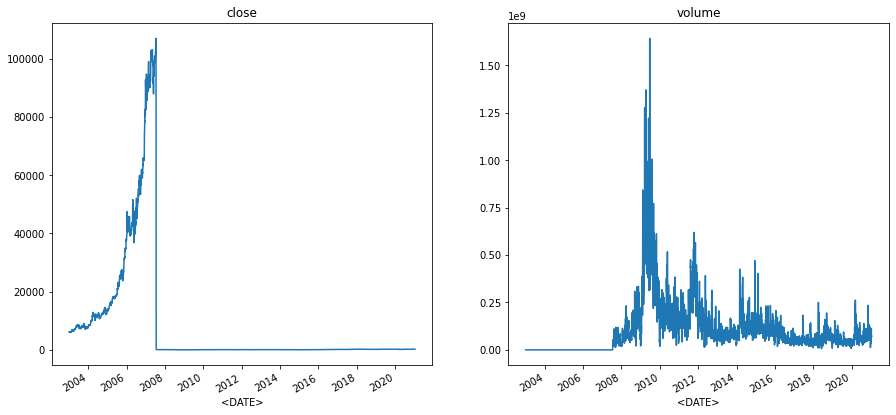

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
data['<CLOSE>'].plot()
plt.title('close')
plt.subplot(1,2,2)
data['<VOL>'].plot()
plt.title('volume')
plt.show()

In [ ]:
def obrRowData(r):
    o,h,l,c,v = r
    if c > 1000:
        r[:-1] /= 1000
        r[-1] *= 1000
    return r

data = data.apply(obrRowData,axis=1)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2003-01-04,6.12000,6.155,6.1000,6.13000,2358000.0
2003-01-05,6.11101,6.145,6.1027,6.14500,956000.0
2003-01-08,6.14500,6.190,5.9600,6.13505,8771000.0
2003-01-09,6.12001,6.250,6.1200,6.22500,10579000.0
2003-01-10,6.24000,6.285,6.2251,6.26100,8882000.0
...,...,...,...,...,...
2021-01-11,282.75000,292.950,279.4800,289.49000,112210400.0
2021-01-12,290.50000,296.070,286.7000,289.99000,78890100.0
2021-01-13,291.01000,292.460,283.1000,283.78000,67489780.0


Text(0.5, 1.0, 'volume')

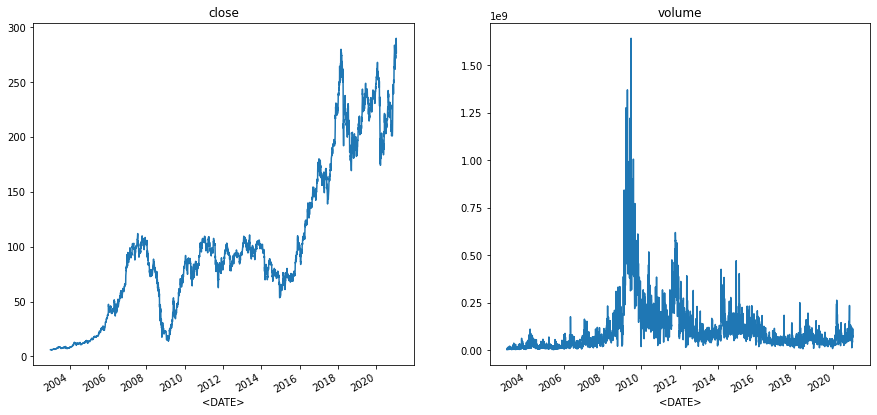

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
data['<CLOSE>'].plot()
plt.title('close')
plt.subplot(1,2,2)
data['<VOL>'].plot()
plt.title('volume')

# Расчет изменения

In [ ]:
ohlcv = data.values[:,:5]
d_ohlcv = np.array(ohlcv)
for n in range(1,len(ohlcv)):
    b = ohlcv[n-1,3]
    d_ohlcv[n,:] = (ohlcv[n,:] - b) / b
d_ohlcv[0,:] = np.nan

data['dOpen'] = d_ohlcv[:,0]
data['dHigh'] = d_ohlcv[:,1]
data['dLow'] = d_ohlcv[:,2]
data['dClose'] = d_ohlcv[:,3]

data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,dOpen,dHigh,dLow,dClose
<DATE>,,,,,,,,,
2003-01-04,6.12000,6.155,6.1000,6.13000,2358000.0,NaN,NaN,NaN,NaN
2003-01-05,6.11101,6.145,6.1027,6.14500,956000.0,-0.003098,0.002447,-0.004454,0.002447
2003-01-08,6.14500,6.190,5.9600,6.13505,8771000.0,0.000000,0.007323,-0.030106,-0.001619
2003-01-09,6.12001,6.250,6.1200,6.22500,10579000.0,-0.002451,0.018737,-0.002453,0.014662
2003-01-10,6.24000,6.285,6.2251,6.26100,8882000.0,0.002410,0.009639,0.000016,0.005783
...,...,...,...,...,...,...,...,...,...
2021-01-11,282.75000,292.950,279.4800,289.49000,112210400.0,-0.003138,0.032823,-0.014666,0.020625
2021-01-12,290.50000,296.070,286.7000,289.99000,78890100.0,0.003489,0.022730,-0.009638,0.001727
2021-01-13,291.01000,292.460,283.1000,283.78000,67489780.0,0.003517,0.008518,-0.023759,-0.021415


# Поиск гиперпараметров

## Целевая функция

In [ ]:
# %%time

allLen = data.shape[0]                      # размер всей выборки
allIdx = np.arange(allLen,dtype=np.int16)
testPart = 0.2                              # доля тестовой
testLen = int(np.round(allLen*testPart))    # длина тестовой выборки
trainLen = allLen - testLen                 # длина трейновой выборки (обучающая + валидационная)

# --------------------------------------------------

def get_X(lookback):
    X = np.hstack([data[['dOpen','dHigh','dLow','dClose','<VOL>']].shift(n) for n in range(lookback)])
    X = np.hstack((X,np.vstack((data.index.month,data.index.day,data.index.dayofweek)).T))
    return X

# --------------------------------------------------

def getQualityMethod(orderLifeLen, # время жизни ордера
                     lookback,     # окно задержки
                     learnLen,     # глубина обучения
                     valLen,       # глубина валидации
                     max_depth,    # максимальная глубина дерева
                     n_estimators, # кол-во эстиматоров
                     dTP,          # тейк-профит
                     dSL):         # стоплос
    
    # (+) !!! - случайная точка расчета
    randomPoint = np.random.randint(1+learnLen+lookback+orderLifeLen,trainLen-valLen)

    # подготовка сигналов
    b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=orderLifeLen,dSL=dSL,dTP=dTP)

    # подготовка входов
    X = get_X(lookback)
    y = b*2+s

    # разделение выборок
    X_learn = X[(randomPoint-learnLen-orderLifeLen):(randomPoint-orderLifeLen)]
    y_learn = y[(randomPoint-learnLen-orderLifeLen):(randomPoint-orderLifeLen)]
    X_valid = X[randomPoint:(randomPoint+valLen)]
    y_valid = y[randomPoint:(randomPoint+valLen)]

    # создание модели

    model = RandomForestClassifier(max_depth=max_depth,class_weight='balanced',n_estimators=n_estimators)

    # обучение модели

    model.fit(X_learn, y_learn)

    # возвращаем точности на отборе генетики
    
    # print(model.evaluate(X_valid,y_valid))
    pred_valid = model.predict(X_valid)
    # print(np.mean(pred_valid,axis=0),np.std(pred_valid,axis=0))
    # print('pred_valid',np.unique(pred_valid,return_counts=True))
    # print('y_valid',np.unique(y_valid,return_counts=True))

    # print(confusion_matrix(y_valid,pred_valid))
    # print(classification_report(y_valid,pred_valid))
    
    # raise Exception(1)
    num2bs = lambda num : np.array([[b,s] for b,s in zip(*y2bs(num))])
    res = kach(num2bs(pred_valid),num2bs(y_valid),dTP,dSL)

    if res == 0.0:  # не нужны тупые бездействующие модели
        res = -0.1

    return res

res = getQualityMethod(5,30,1000,60,7,200,0.004,0.01)
print(res)

-0.0002666666666666667


## Создание модели

### Создание

In [ ]:
modelGA = ListGenetic(pop_size = 200,
                      orderLifeLen = range(2,10),
                      lookback = range(10,300),
                      learnLen = range(100,2000),
                      valLen = range(2,50),
                      max_depth = range(2,100),
                      n_estimators = range(10,500),
                      dTP = np.round(np.arange(0.0001,0.1,0.0001),4),
                      dSL = np.round(np.arange(0.0001,0.1,0.0001),4),
                      quality_method=getQualityMethod)

### или загрузка с диска

In [ ]:
fn = '/content/drive/My Drive/prog/model_vjo_16.01.2021.pkl'

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)


## Бесконечный цикл обучения

In [ ]:
while True:
    modelGA.fit(50,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

15 {'quality': -0.1, 'orderLifeLen': 3, 'lookback': 261, 'learnLen': 1619, 'valLen': 45, 'max_depth': 14, 'n_estimators': 293, 'dTP': 0.0569, 'dSL': 0.0475}
45 {'quality': -0.0003540816326530611, 'orderLifeLen': 3, 'lookback': 229, 'learnLen': 1671, 'valLen': 49, 'max_depth': 15, 'n_estimators': 218, 'dTP': 0.0125, 'dSL': 0.0243}
finish -  50 {'quality': -0.0023132653061224487, 'orderLifeLen': 6, 'lookback': 10, 'learnLen': 822, 'valLen': 49, 'max_depth': 12, 'n_estimators': 290, 'dTP': 0.0559, 'dSL': 0.0873}
72 {'quality': -0.1, 'orderLifeLen': 4, 'lookback': 295, 'learnLen': 1390, 'valLen': 45, 'max_depth': 35, 'n_estimators': 365, 'dTP': 0.0349, 'dSL': 0.0516}
90 {'quality': -0.1, 'orderLifeLen': 4, 'lookback': 32, 'learnLen': 1530, 'valLen': 27, 'max_depth': 74, 'n_estimators': 278, 'dTP': 0.0759, 'dSL': 0.0171}
finish -  100 {'quality': -0.1, 'orderLifeLen': 2, 'lookback': 208, 'learnLen': 115, 'valLen': 27, 'max_depth': 15, 'n_estimators': 41, 'dTP': 0.0999, 'dSL': 0.0745}
117 {'

KeyboardInterrupt: ignored

## Графики оптимизации параметров в генетике

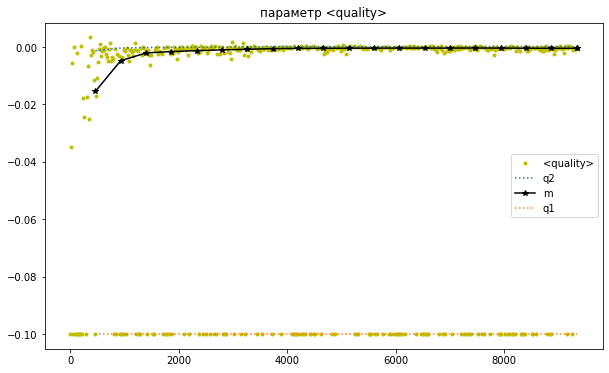

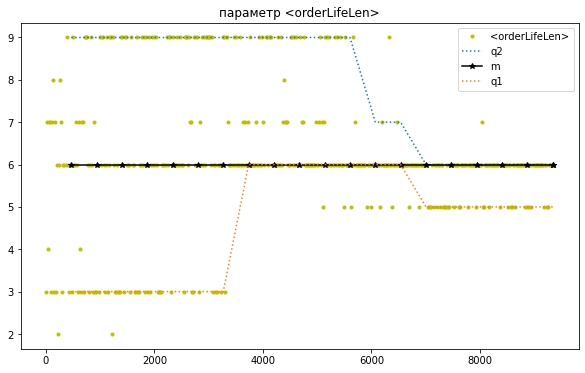

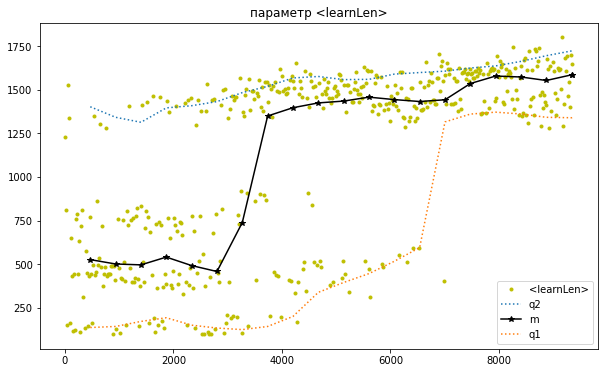

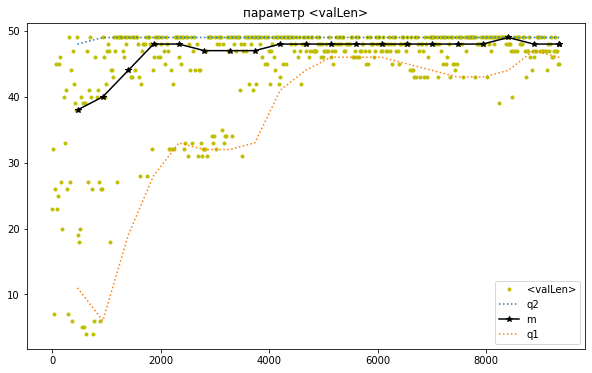

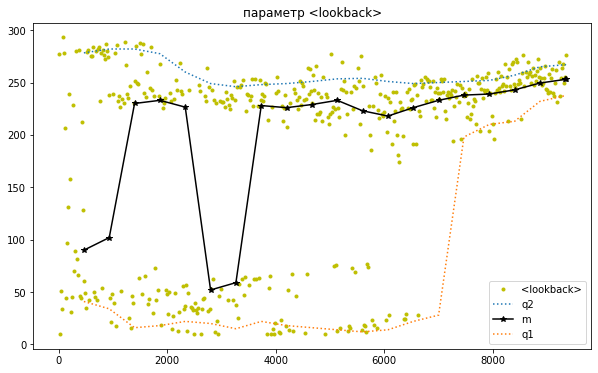

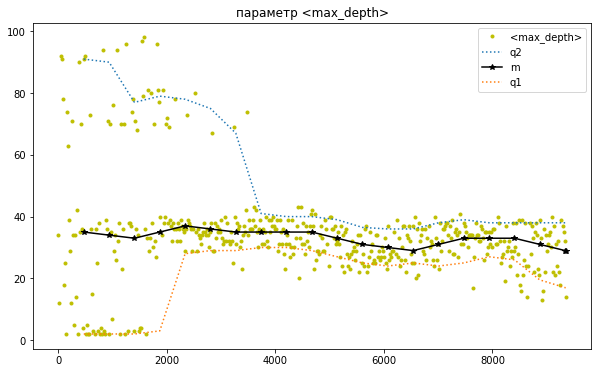

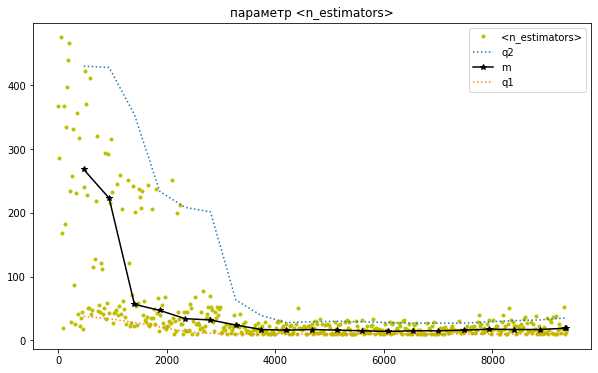

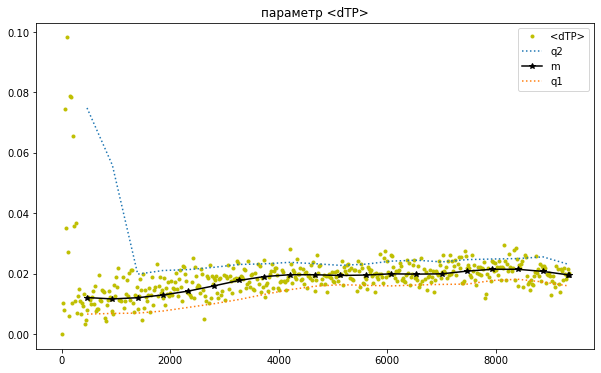

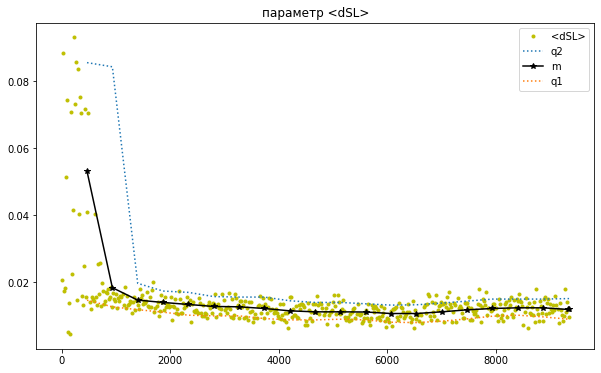

In [ ]:
modelGA.plot_hist_new(('quality','orderLifeLen','learnLen','valLen','lookback','max_depth','n_estimators','dTP','dSL'))

## Положительные

In [ ]:
for n,h in enumerate(modelGA._hist):
    if h['new']['quality'] > 0:
        print(n,h['new'])


16 {'quality': 0.0006895833333333333, 'orderLifeLen': 9, 'lookback': 160, 'learnLen': 740, 'valLen': 48, 'max_depth': 97, 'n_estimators': 123, 'dTP': 0.0662, 'dSL': 0.0742}
40 {'quality': 0.0019500000000000001, 'orderLifeLen': 5, 'lookback': 246, 'learnLen': 1588, 'valLen': 11, 'max_depth': 13, 'n_estimators': 214, 'dTP': 0.0129, 'dSL': 0.0366}
75 {'quality': 0.00012000000000000014, 'orderLifeLen': 6, 'lookback': 134, 'learnLen': 472, 'valLen': 40, 'max_depth': 26, 'n_estimators': 234, 'dTP': 0.0485, 'dSL': 0.0402}
93 {'quality': 0.003213636363636363, 'orderLifeLen': 5, 'lookback': 247, 'learnLen': 1570, 'valLen': 11, 'max_depth': 13, 'n_estimators': 125, 'dTP': 0.013, 'dSL': 0.0853}
123 {'quality': 0.0032150000000000013, 'orderLifeLen': 7, 'lookback': 69, 'learnLen': 149, 'valLen': 20, 'max_depth': 4, 'n_estimators': 430, 'dTP': 0.0079, 'dSL': 0.0858}
158 {'quality': 0.0009314285714285715, 'orderLifeLen': 9, 'lookback': 162, 'learnLen': 774, 'valLen': 35, 'max_depth': 97, 'n_estimator

## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'dSL': 0.0118,
 'dTP': 0.019,
 'learnLen': 1597,
 'lookback': 251,
 'max_depth': 28,
 'n_estimators': 23,
 'orderLifeLen': 6,
 'valLen': 47}

# Тестирование лучшей

## входы и выходы обучения

In [ ]:
# подготовка сигналов
b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=best_par['orderLifeLen'],dSL=best_par['dSL'],dTP=best_par['dTP'])

# подготовка входов
X = get_X(best_par['lookback'])
y = b*2+s

## цикл расчета

In [ ]:
b_ = b * np.nan
s_ = s * np.nan

dLen = min(6,best_par['valLen'])

# цикл по точкам расчета
for calcPoint in range(best_par['learnLen']+best_par['lookback']+best_par['orderLifeLen'],allLen-best_par['valLen'],dLen):
    
    # обучающая выборка
    X_learn = X[(calcPoint-best_par['learnLen']-best_par['orderLifeLen']):(calcPoint-best_par['orderLifeLen'])]
    y_learn = y[(calcPoint-best_par['learnLen']-best_par['orderLifeLen']):(calcPoint-best_par['orderLifeLen'])]
    X_test = X[calcPoint:(calcPoint+dLen)]
    
    # создание модели
    model_test = RandomForestClassifier(max_depth=best_par['max_depth'],class_weight='balanced',n_estimators=best_par['n_estimators'])

    # обучение модели
    model_test.fit(X_learn, y_learn)

    # прогноз модели
    pred_test = model_test.predict(X_test)
    b_test,s_test = y2bs(pred_test)

    # запись результатов
    b_[calcPoint:(calcPoint+dLen)] = b_test
    s_[calcPoint:(calcPoint+dLen)] = s_test

    print(calcPoint,allLen)



1854 4496
1860 4496
1866 4496
1872 4496
1878 4496
1884 4496
1890 4496
1896 4496
1902 4496
1908 4496
1914 4496
1920 4496
1926 4496
1932 4496
1938 4496
1944 4496
1950 4496
1956 4496
1962 4496
1968 4496
1974 4496
1980 4496
1986 4496
1992 4496
1998 4496
2004 4496
2010 4496
2016 4496
2022 4496
2028 4496
2034 4496
2040 4496
2046 4496
2052 4496
2058 4496
2064 4496
2070 4496
2076 4496
2082 4496
2088 4496
2094 4496
2100 4496
2106 4496
2112 4496
2118 4496
2124 4496
2130 4496
2136 4496
2142 4496
2148 4496
2154 4496
2160 4496
2166 4496
2172 4496
2178 4496
2184 4496
2190 4496
2196 4496
2202 4496
2208 4496
2214 4496
2220 4496
2226 4496
2232 4496
2238 4496
2244 4496
2250 4496
2256 4496
2262 4496
2268 4496
2274 4496
2280 4496
2286 4496
2292 4496
2298 4496
2304 4496
2310 4496
2316 4496
2322 4496
2328 4496
2334 4496
2340 4496
2346 4496
2352 4496
2358 4496
2364 4496
2370 4496
2376 4496
2382 4496
2388 4496
2394 4496
2400 4496
2406 4496
2412 4496
2418 4496
2424 4496
2430 4496
2436 4496
2442 4496
2448 4496


## Таблица результатов

In [ ]:
df_=pd.DataFrame(index=data.index)
df_['BUY'] = b_
df_['BUY_open'] = data['<CLOSE>']
df_['BUY_tp'] = np.round(data['<CLOSE>']*(1+best_par['dTP']),2)
df_['BUY_sl'] = np.round(data['<CLOSE>']*(1-best_par['dSL']),2)
df_['SELL'] = s_
df_['SELL_open'] = data['<CLOSE>']
df_['SELL_tp'] = np.round(data['<CLOSE>']*(1-best_par['dTP']),2)
df_['SELL_sl'] = np.round(data['<CLOSE>']*(1+best_par['dSL']),2)
df_

,BUY,BUY_open,BUY_tp,BUY_sl,SELL,SELL_open,SELL_tp,SELL_sl
<DATE>,,,,,,,,
2003-01-04,NaN,6.13000,6.25,6.06,NaN,6.13000,6.01,6.20
2003-01-05,NaN,6.14500,6.26,6.07,NaN,6.14500,6.03,6.22
2003-01-08,NaN,6.13505,6.25,6.06,NaN,6.13505,6.02,6.21
2003-01-09,NaN,6.22500,6.34,6.15,NaN,6.22500,6.11,6.30
2003-01-10,NaN,6.26100,6.38,6.19,NaN,6.26100,6.14,6.33
...,...,...,...,...,...,...,...,...
2021-01-11,NaN,289.49000,294.99,286.07,NaN,289.49000,283.99,292.91
2021-01-12,NaN,289.99000,295.50,286.57,NaN,289.99000,284.48,293.41
2021-01-13,NaN,283.78000,289.17,280.43,NaN,283.78000,278.39,287.13


## Сигналы

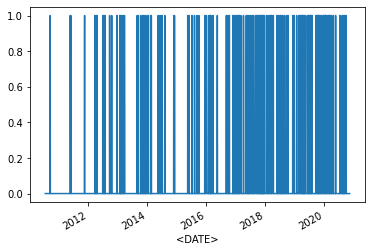

In [ ]:
df_['BUY'].plot()

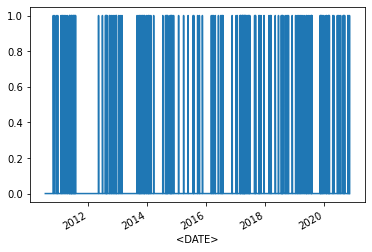

In [ ]:
df_['SELL'].plot()

## Качество на тесте

In [ ]:
bs_y = np.vstack((b,s)).T
bs_y_ = np.vstack((b_,s_)).T
idx = ~np.any(np.isnan(bs_y + bs_y_),axis=1)

trainIdx = np.copy(idx)
trainIdx[trainLen:] = False
kachTrain = kach(bs_y_[trainIdx],bs_y[trainIdx],best_par['dTP'],best_par['dSL'])
print('kachTrain',kachTrain,'%/year',((kachTrain+1)**252-1)*100)

testIdx = np.copy(idx)
testIdx[:trainLen] = False
kachTest = kach(bs_y_[testIdx],bs_y[testIdx],best_par['dTP'],best_par['dSL'])
print('kachTest',kachTest,'%/year',((kachTest+1)**252-1)*100)

kachTrain -0.00022375215146299484 %/year -5.483130226895705
kachTest -0.00044152046783625724 %/year -10.531871261515025


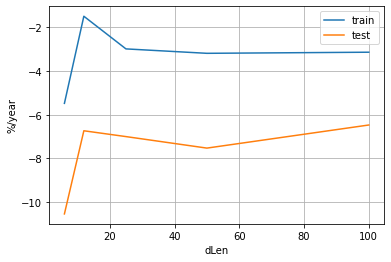

In [ ]:
testRes = np.array([[100,-3.1476713325952588,-6.471737151811407],
                    [50,-3.198074549809693,-7.52652761633038],
                    [25,-2.996304787221571,-7.0010280141528884],
                    [12,-1.5052286006159932,-6.735133951617145],
                    [6,-5.483130226895705,-10.531871261515025]])
plt.plot(testRes[:,0],testRes[:,1:])
plt.legend(['train','test'])
plt.ylabel('%/year')
plt.xlabel('dLen')
plt.grid()
plt.show()
